In [1]:
%pylab inline
import os
import calin.simulation.vs_optics;
import calin.io.sql_transceiver;
import calin.math.hex_array;

Populating the interactive namespace from numpy and matplotlib


In [2]:
rng = calin.math.rng.RNG()

In [3]:
def dms(d,m,s):
    sign = 1
    if(d<0):
        sign = -1
        d = abs(d)
    return sign * (d + m/60.0 + s/3600.0)

In [4]:
mst = calin.ix.simulation.vs_optics.IsotropicDCArrayParameters()
mst.mutable_array_origin().set_latitude(dms(28, 45, 47.36))
mst.mutable_array_origin().set_longitude(dms(-17, 53, 23.93))
mst.mutable_array_origin().set_elevation(2178.0)
mst.mutable_prescribed_array_layout().add_scope_positions();
mst.mutable_reflector_frame().set_optic_axis_rotation(-90);
dc = mst.mutable_reflector()
dc.set_curvature_radius(1920)
dc.set_aperture(1230)
dc.set_facet_num_hex_rings(5)
dc.mutable_psf_align().set_object_plane(inf);
dc.set_facet_spacing(122)
dc.set_facet_size(120)
dc.set_facet_focal_length(1607)
dc.set_facet_spot_size_probability(0.8)
dc.set_facet_spot_size(0)
dc.set_facet_labeling_parity(True)
dc.set_weathering_factor(1.0)
for id in [1,62,67,72,77,82,87]: dc.add_facet_missing_list(id-1)
mst.mutable_focal_plane().set_camera_diameter(235)
mst.mutable_focal_plane().mutable_translation().set_y(1600)
mst.mutable_pixel().set_spacing(5)
mst.mutable_pixel().set_cone_inner_diameter(5)
mst.mutable_pixel().set_cone_survival_prob(1)
mst.mutable_pixel().set_hex_module_size(1)
mst.mutable_pixel().set_module_num_hex_rings(9)
u1,v1 = calin.math.hex_array.cluster_hexid_to_center_uv(1,1)
x1,y1 = calin.math.hex_array.uv_to_xy(u1,v1)
rot = -arctan2(-y1,x1)/pi*180 + 30
mst.mutable_pixel().set_grid_rotation(rot)
#mst.mutable_focal_plane().mutable_rotation().set_y(rot)

In [5]:
cta = calin.simulation.vs_optics.VSOArray()
cta.generateFromArrayParameters(mst, rng)

In [6]:
cta.pointTelescopesAzEl(0,45./180.0*pi);

In [7]:
raytracer = calin.simulation.vs_optics.VSORayTracer(cta,rng)

In [8]:
psf = calin.simulation.vs_optics.VSOPSFInfo()

In [9]:
scope = cta.telescope(0)
pos = scope.position()
ax = scope.opticalAxis()
beam_dir = calin.math.vs_physics.Vec3D(ax)
beam_dir *= -1.0
beam_cen = calin.math.vs_physics.Vec3D(pos)
F = scope.focalPlanePosition().y
PS = 1/F
print(F, PS)
print(pos.x, pos.y, pos.z)
print(ax.x, ax.y, ax.z)
print(beam_dir.x, beam_dir.y, beam_dir.z)
print(beam_cen.x, beam_cen.y, beam_cen.z)

1600.0 0.000625
0.0 0.0 0.0
0.0 0.7071067811865476 0.7071067811865475
-0.0 -0.7071067811865476 -0.7071067811865475
0.0 0.0 0.0


In [21]:
ph = calin.math.vs_physics.Particle()
info = calin.simulation.vs_optics.VSOTraceInfo()
x = []
y = []
for theta in arange(0.0,4.0,0.5):
    beam_dir_offset = calin.math.vs_physics.Vec3D(beam_dir)
    beam_rot = calin.math.vs_physics.Vec3D(theta/180.0*pi,0,0)
    beam_dir_offset.Rotate(beam_rot)
    print(theta,beam_dir_offset.x,beam_dir_offset.y,beam_dir_offset.z,beam_rot.x,beam_rot.y,beam_rot.z)
    for i in range(0,10000):
        raytracer.laserBeam(ph, beam_cen, beam_dir_offset, -1.0*scope.curvatureRadius(), scope.aperture()*0.55, 300)
        pixel = raytracer.trace(ph, info, scope)
#        info.write()
#        print(info.status)
        if info.status==15:
            x.append(info.fplane_x)
            y.append(info.fplane_z)
    print(len(y))
x = asarray(x)*PS/pi*180
y = asarray(y)*PS/pi*180
print(len(y))

0.0 -0.0 -0.7071067811865476 -0.7071067811865475 0.0 0.0 0.0
7225
0.5 0.0 -0.700909264299851 -0.7132504491541816 0.008726646259971648 0.0 0.0
14391
1.0 0.0 -0.6946583704589974 -0.7193398003386511 0.017453292519943295 0.0 0.0
21612
1.5 0.0 -0.688354575693754 -0.7253743710122875 0.02617993877991494 0.0 0.0
28780
2.0 0.0 -0.6819983600624986 -0.7313537016191705 0.03490658503988659 0.0 0.0
36011
2.5 0.0 -0.6755902076156602 -0.737277336810124 0.04363323129985824 0.0 0.0
43199
3.0 0.0 -0.6691306063588582 -0.7431448254773941 0.05235987755982988 0.0 0.0
50456
3.5 0.0 -0.6626200482157375 -0.7489557207890021 0.061086523819801536 0.0 0.0
57664
57664


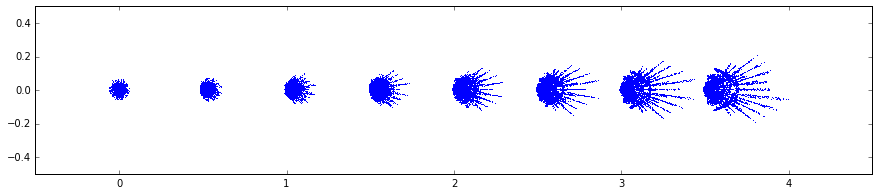

In [22]:
figure(1, figsize=[ 15, 3 ])
plot(-y,x,',')
#a=axis()
#da=max(a[1]-a[0], a[3]-a[2])/2
#axis([(a[1]+a[0])/2-da, (a[1]+a[0])/2+da, (a[3]+a[2])/2-da, (a[3]+a[2])/2+da]);
axis([-0.5, 4.5, -0.5, 0.5]);

In [12]:
ph = calin.math.vs_physics.Particle()
info = calin.simulation.vs_optics.VSOTraceInfo()
x = []
y = []
mu_angle = 1.25 / 180 * pi
for theta in arange(0.0,6.0,1):
    beam_dir_offset = calin.math.vs_physics.Vec3D(beam_dir)
    beam_rot = calin.math.vs_physics.Vec3D(theta/180.0*pi,0,0)
    beam_dir_offset.Rotate(beam_rot)
    for i in range(0,10000):
        raytracer.muonBeam(ph, beam_cen, beam_dir_offset, -scope.aperture()*0.55/tan(mu_angle), mu_angle)
        pixel = raytracer.trace(ph, info, scope)
    #    info.write()
    #    print(info.status)
        if info.status==15:
            x.append(info.fplane_x)
            y.append(info.fplane_z)

x = asarray(x)*PS/pi*180
y = asarray(y)*PS/pi*180
print(len(y))

32228


1.60068346564 -0.0216241463395 1.7787100978 -0.0551467860348


(-1.5, 6.5, -1.6, 1.6)

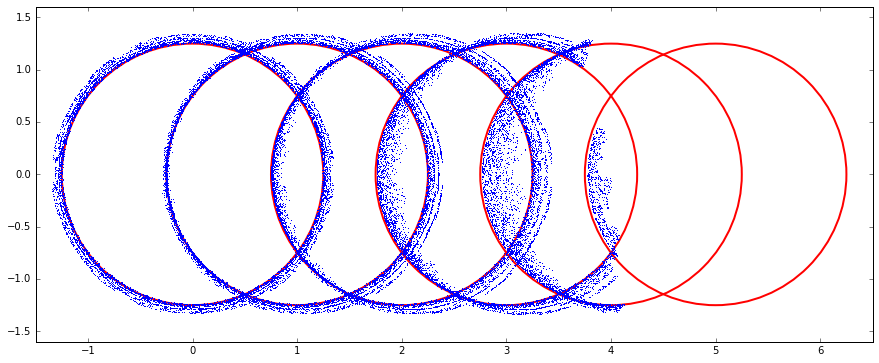

In [13]:
figure(1, figsize=[ 15, 6 ])
xx = -y
yy = x
plot(xx,yy,',')
print(mean(xx),mean(yy),median(xx),median(yy))
#gca().add_artist(Circle((theta,0),mu_angle/pi*180,color='r',lw=2,fill=False))
for theta in arange(0.0,6.0,1):
        gca().add_artist(Circle((theta,0),mu_angle/pi*180,color='r',lw=2,fill=False))
axis((-1.5,6.5,-1.6,1.6))
#axis('square')

In [23]:
ph = calin.math.vs_physics.Particle()
info = calin.simulation.vs_optics.VSOTraceInfo()
x = []
y = []
mu_angle = 1.25 / 180 * pi
for theta in arange(0.0,6.0,1):
    beam_dir_offset = calin.math.vs_physics.Vec3D(beam_dir)
    beam_rot = calin.math.vs_physics.Vec3D(theta/180.0*pi,0,0)
    beam_dir_offset.Rotate(beam_rot)
    for i in range(0,10000):
        raytracer.muonBeam(ph, beam_cen+calin.math.vs_physics.Vec3D(500,0,0), beam_dir_offset, -scope.aperture()*0.55/tan(mu_angle), mu_angle)
        pixel = raytracer.trace(ph, info, scope)
    #    info.write()
    #    print(info.status)
        if info.status==15:
            x.append(info.fplane_x)
            y.append(info.fplane_z)

x = asarray(x)*PS/pi*180
y = asarray(y)*PS/pi*180
print(len(y))

23086


1.65659058479 -0.591277269955 1.7909354578 -0.83247025419


(-1.5, 6.5, -1.6, 1.6)

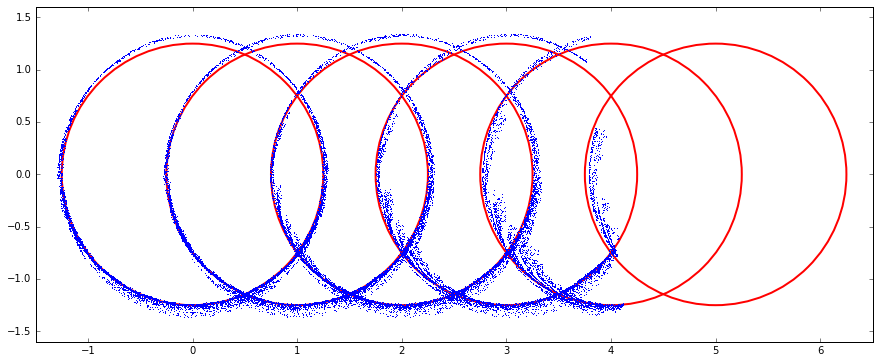

In [24]:
figure(1, figsize=[ 15, 6 ])
xx = -y
yy = x
plot(xx,yy,',')
print(mean(xx),mean(yy),median(xx),median(yy))
#gca().add_artist(Circle((theta,0),mu_angle/pi*180,color='r',lw=2,fill=False))
for theta in arange(0.0,6.0,1):
        gca().add_artist(Circle((theta,0),mu_angle/pi*180,color='r',lw=2,fill=False))
axis((-1.5,6.5,-1.6,1.6))
#axis('square')

In [25]:
ph = calin.math.vs_physics.Particle()
info = calin.simulation.vs_optics.VSOTraceInfo()
x = []
y = []
mu_angle = 1.25 / 180 * pi
for theta in arange(0.0,6.0,1):
    beam_dir_offset = calin.math.vs_physics.Vec3D(beam_dir)
    beam_rot = calin.math.vs_physics.Vec3D(theta/180.0*pi,0,0)
    beam_dir_offset.Rotate(beam_rot)
    for i in range(0,10000):
        raytracer.muonBeam(ph, beam_cen+calin.math.vs_physics.Vec3D(500,0,0).cross(beam_dir), beam_dir_offset, -scope.aperture()*0.55/tan(mu_angle), mu_angle)
        pixel = raytracer.trace(ph, info, scope)
    #    info.write()
    #    print(info.status)
        if info.status==15:
            x.append(info.fplane_x)
            y.append(info.fplane_z)

x = asarray(x)*PS/pi*180
y = asarray(y)*PS/pi*180
print(len(y))

26007


1.40044926685 -0.0241313118734 1.42422531986 -0.0553767529558


(-1.5, 6.5, -1.6, 1.6)

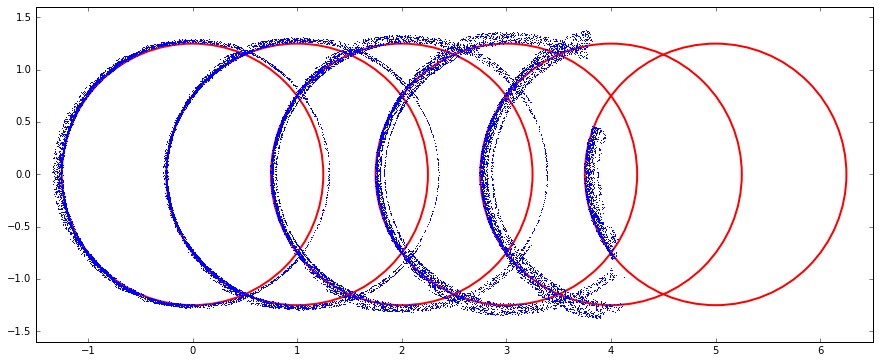

In [26]:
figure(1, figsize=[ 15, 6 ])
xx = -y
yy = x
plot(xx,yy,',')
print(mean(xx),mean(yy),median(xx),median(yy))
#gca().add_artist(Circle((theta,0),mu_angle/pi*180,color='r',lw=2,fill=False))
for theta in arange(0.0,6.0,1):
        gca().add_artist(Circle((theta,0),mu_angle/pi*180,color='r',lw=2,fill=False))
axis((-1.5,6.5,-1.6,1.6))
#axis('square')

In [27]:
ph = calin.math.vs_physics.Particle()
info = calin.simulation.vs_optics.VSOTraceInfo()
x = []
y = []
mu_angle = 1.25 / 180 * pi
for theta in arange(0.0,6.0,1):
    beam_dir_offset = calin.math.vs_physics.Vec3D(beam_dir)
    beam_rot = calin.math.vs_physics.Vec3D(theta/180.0*pi,0,0)
    beam_dir_offset.Rotate(beam_rot)
    for i in range(0,10000):
        raytracer.muonBeam(ph, beam_cen-calin.math.vs_physics.Vec3D(500,0,0).cross(beam_dir), beam_dir_offset, -scope.aperture()*0.55/tan(mu_angle), mu_angle)
        pixel = raytracer.trace(ph, info, scope)
    #    info.write()
    #    print(info.status)
        if info.status==15:
            x.append(info.fplane_x)
            y.append(info.fplane_z)

x = asarray(x)*PS/pi*180
y = asarray(y)*PS/pi*180
print(len(y))

18792


1.90622836422 -0.0313955959362 2.02205647791 -0.0966233325347


(-1.5, 6.5, -1.6, 1.6)

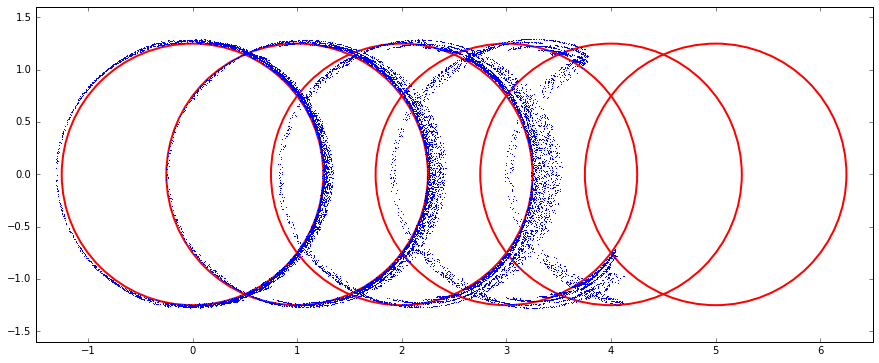

In [28]:
figure(1, figsize=[ 15, 6 ])
xx = -y
yy = x
plot(xx,yy,',')
print(mean(xx),mean(yy),median(xx),median(yy))
#gca().add_artist(Circle((theta,0),mu_angle/pi*180,color='r',lw=2,fill=False))
for theta in arange(0.0,6.0,1):
        gca().add_artist(Circle((theta,0),mu_angle/pi*180,color='r',lw=2,fill=False))
axis((-1.5,6.5,-1.6,1.6))
#axis('square')